## Imports

In [1]:
# Surpresses printing from other notebook
import io
import sys

original_stdout = sys.stdout
sys.stdout = io.StringIO()
%run evolution_strategies.ipynb
sys.stdout = original_stdout

In [2]:
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from io import BytesIO
from ipywidgets import widgets
from matplotlib.colors import Normalize
import seaborn as sns

np.set_printoptions(precision=4, suppress=True) # for better printing
sns.set_style("darkgrid")

# Problem: Ackley function

We use now your algorithm to search for the maximum of the Ackley function. 

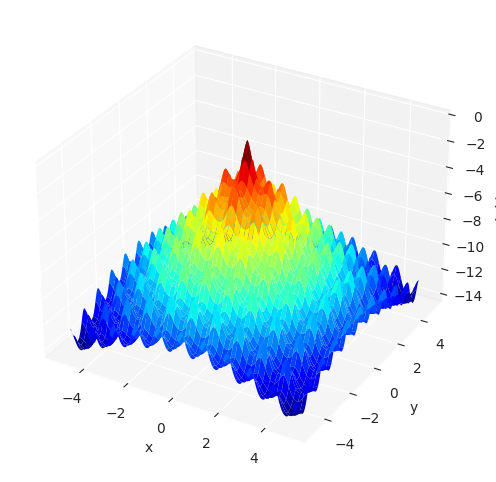

In [3]:
def f_reversed_ackley(x, y):
    return -1*(-20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2))) - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))) + np.e + 20)

r_min, r_max = -5.0, 5.0
xaxis = np.arange(r_min, r_max, 0.01)
yaxis = np.arange(r_min, r_max, 0.01)
x, y = np.meshgrid(xaxis, yaxis)

results = f_reversed_ackley(x, y)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')
ax.patch.set_facecolor('white')
surf = ax.plot_surface(x, y, results, cmap='jet', edgecolor='none')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("Ackley")
plt.show()

## Step 4: Evaluate $\lambda$ offspring (Ackley function) 
The evaluation function takes each candidate from the population and infers their fitness.

In [4]:
def evaluate_population_ackley(population):
    population_size = population.shape[0]
    fitness = np.zeros((population_size,))
        
    for i in range(population_size):
        x, y = population[i, :]  
        
        fitness[i] = f_reversed_ackley(x,y)
    
    return fitness

In [5]:
# Test function:
test_population = np.array([[1.0, -1.0], [0.23, 0.23], [-2.1, 4.3], [-14.0, 14.0], [0.0, 0.0], [0.3, 0.1]])

fitness = evaluate_population_ackley(test_population)
print(fitness)

[ -3.6254  -2.4839 -11.269  -18.7838  -0.      -2.309 ]


## Run evolution
We can use now our implemented functions to run evolution to find our global maximum at 0.0. There are three visualisations prepared for better understanding of the optimization.

-------
## **Questions**
Let us better understand the influence of our parameters for our evolutionary process. 
1. How does the mutation rate $\sigma$ `mutation_sigma` influence the rate of convergence when you have a small vs large values?
2. Why should the number of parents ($\mu$) be less than the number of children ($\sigma$)?
3. How does a large $\mu$/$\lambda$ ratio influence the convergence rate?
4. We can also introduce a learning schedule by a decaying mutation rate. At $1.0$ there is no decay. How do different decay rates influence the learning process?

-------

In [6]:
# Environment parameters
num_parameters = 2 # dim of ackley - do not change this.

# ES parameters
num_generations = 50
mutation_sigma = 0.5
population_size = 64
num_parents = 16

sigma_decay = 1.00 # [0.0, 1.0]
sigma_limit = 0.01

# Logging
population_log = []
fitness_log = []

# Evolution
mean_vector = initialise_mean(num_parameters)

# Control of mutation rate
def exp_decay(sigma, sigma_decay, sigma_limit):
    sigma = sigma * sigma_decay
    return np.max((sigma_limit, sigma))

# Evolutionary loop
for gen in range(num_generations):
    population = generate_mutated_offspring(population_size, mean_vector, mutation_sigma)
    fitness = evaluate_population_ackley(population)
    
    parents_population, parents_fitness = sort_and_select_parents(population, fitness, num_parents)
    mean_vector = update_population_mean(parents_population, parents_fitness)
    
    # Learning schedule to reduce mutation with time
    mutation_sigma = exp_decay(mutation_sigma, sigma_decay, sigma_limit)
    
     # For visualisation
    population_log.append(population)
    fitness_log.append(fitness)
    
    if gen % 5 == 0:
        print(f"Best fitness in generation {gen}: {np.max(fitness)}")

Best fitness in generation 0: -5.362706386559601
Best fitness in generation 5: -0.4090039504701686
Best fitness in generation 10: -0.3604346054166996
Best fitness in generation 15: -0.9727677761630318
Best fitness in generation 20: -0.13416305429185726
Best fitness in generation 25: -0.1474011358131655
Best fitness in generation 30: -0.23081723368816753
Best fitness in generation 35: -0.5039320856579899
Best fitness in generation 40: -0.9386066944941049
Best fitness in generation 45: -0.10171624218753905


### Visualise evolution

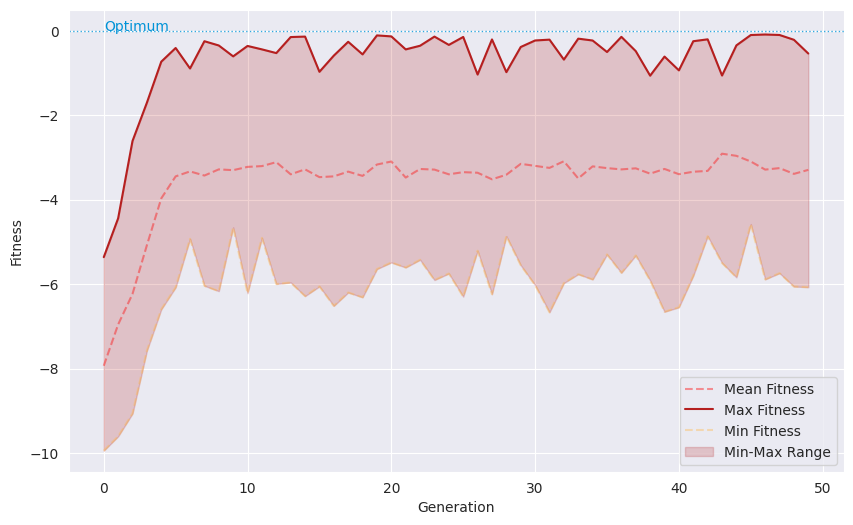

In [7]:
# Calculate mean, min, and max fitness for each generation
mean_fitness = np.mean(fitness_log, axis=1)
min_fitness = np.min(fitness_log, axis=1)
max_fitness = np.max(fitness_log, axis=1)

# Generate the generations array
generations = np.arange(len(mean_fitness))

# Plotting
plt.figure(figsize=(10, 6))

plt.annotate("Optimum", xy= (0, f_reversed_ackley(0.0, 0.0)), color="#0193d7")
plt.axhline(y=f_reversed_ackley(0.0, 0.0), linestyle="dotted", linewidth=1.0, alpha=0.8, color="#0193d7")

plt.plot(generations, mean_fitness, label='Mean Fitness', linestyle="dashed", color="#FF0000", alpha=0.4)
plt.plot(generations, max_fitness, label='Max Fitness', color="#B51F1F")
plt.plot(generations, min_fitness, label='Min Fitness', linestyle="dashed", color="#ffba4d", alpha=0.4)
plt.fill_between(generations, min_fitness, max_fitness, color="#B51F1F", alpha=0.2, label='Min-Max Range')

plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Function to plot the Ackley function surface
def plot_ackley_function(ax):
    xaxis = np.arange(-5.0, 5.0, 0.1)
    yaxis = np.arange(-5.0, 5.0, 0.1)
    x, y = np.meshgrid(xaxis, yaxis)
    results = f_reversed_ackley(x, y)
    cf = ax.contourf(xaxis, yaxis, results, levels=100, cmap='jet', alpha=0.5)

# Create a widget for displaying the plot
image_widget = widgets.Image(format='png')
display(image_widget)

def update_image(frame):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.patch.set_facecolor('white')
    plot_ackley_function(ax)
    generation = population_log[frame]
    fitness = fitness_log[frame]
    best_member_index = np.argmax(fitness)
    best_member = generation[best_member_index]
    ax.scatter(generation[:, 0], generation[:, 1], fitness, c='blue', marker='o', alpha=0.4)
    ax.scatter(best_member[0], best_member[1], fitness[best_member_index], c='red', marker='o')
    ax.text2D(0.05, 0.95, f"Generation: {frame}", transform=ax.transAxes)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Fitness')

    with BytesIO() as output:
        fig.savefig(output, format="png")
        plt.close(fig)
        image_data = output.getvalue()
        image_widget.value = image_data

# Run and update plot for each generation
for gen in range(num_generations):
    update_image(gen)
    clear_output(wait=True)

Image(value=b'')

In [9]:
# Function to create a 2D plot of the population
def plot_population_2d(ax, generation, fitness):
    # Plotting the reversed Ackley function as a background
    xaxis = np.arange(-5.0, 5.0, 0.1)
    yaxis = np.arange(-5.0, 5.0, 0.1)
    x, y = np.meshgrid(xaxis, yaxis)
    results = f_reversed_ackley(x, y)
    cf = ax.contourf(xaxis, yaxis, results, levels=100, cmap='jet')
    
    # Normalize fitness values for consistent coloring
    norm = Normalize(vmin=np.min(results), vmax=np.max(results))
    colors = plt.cm.jet(norm(fitness))

    # Plotting the population
    ax.scatter(generation[:, 0], generation[:, 1], color=colors, edgecolor='k')
    return cf

# Create a widget for displaying the 2D plot
image_widget_2d = widgets.Image(format='png')
display(image_widget_2d)

def update_image_2d(frame):
    fig, ax = plt.subplots()
    generation = population_log[frame]
    fitness = fitness_log[frame]
    cf = plot_population_2d(ax, generation, fitness)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f"Generation: {frame}")

    with BytesIO() as output:
        fig.colorbar(cf, ax=ax)
        fig.savefig(output, format="png")
        plt.close(fig)
        image_data = output.getvalue()
        image_widget_2d.value = image_data

# Run and update plot for each generation
for gen in range(num_generations):
    update_image_2d(gen)
    clear_output(wait=True)

Image(value=b'')